<a href="https://colab.research.google.com/github/BautiSobenko/IA-2022/blob/main/Ej3_DatosSimulados_Sugeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

### **Subtractive Algorithm**

In [3]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)

    return labels, centers

### **Sugeno Algorithm**

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))
    
class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma
    
class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    
    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure(figsize=(12,12))
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.title("GAUSSIANAS - REGLAS: {}".format(self.centroids.size))
            plt.xlabel("X") # Agregamos labels a los ejes
            plt.ylabel("Grado de pertenencia μ")
            plt.plot(x,y)
        
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        
   
    
    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)
        
        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)
        
        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)       
     
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        
        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        
        
        A = acti*inp/sumMu
        
        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu
        
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
         
        P = np.c_[data, np.ones(len(data))]
        
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        
        return np.sum(acti*inp*coef/sumMu,axis=1)
        
    
    def viewInputs(self):
        for input in self.inputs:
            input.view()

Genero datos simulados

In [5]:
# Valores de parametros
A = 10
B = -5
C = 2

df = np.zeros((0,2))

for x in np.arange(0.01,1,0.01):
  y = A * math.exp(-B * x) + C
  row = np.array( [x,y] )
  df = np.vstack( [df, row] )

In [6]:
df

array([[1.00000000e-02, 1.25127110e+01],
       [2.00000000e-02, 1.30517092e+01],
       [3.00000000e-02, 1.36183424e+01],
       [4.00000000e-02, 1.42140276e+01],
       [5.00000000e-02, 1.48402542e+01],
       [6.00000000e-02, 1.54985881e+01],
       [7.00000000e-02, 1.61906755e+01],
       [8.00000000e-02, 1.69182470e+01],
       [9.00000000e-02, 1.76831219e+01],
       [1.00000000e-01, 1.84872127e+01],
       [1.10000000e-01, 1.93325302e+01],
       [1.20000000e-01, 2.02211880e+01],
       [1.30000000e-01, 2.11554083e+01],
       [1.40000000e-01, 2.21375271e+01],
       [1.50000000e-01, 2.31700002e+01],
       [1.60000000e-01, 2.42554093e+01],
       [1.70000000e-01, 2.53964685e+01],
       [1.80000000e-01, 2.65960311e+01],
       [1.90000000e-01, 2.78570966e+01],
       [2.00000000e-01, 2.91828183e+01],
       [2.10000000e-01, 3.05765112e+01],
       [2.20000000e-01, 3.20416602e+01],
       [2.30000000e-01, 3.35819291e+01],
       [2.40000000e-01, 3.52011692e+01],
       [2.500000

### **Ploteo de los datos simulados**

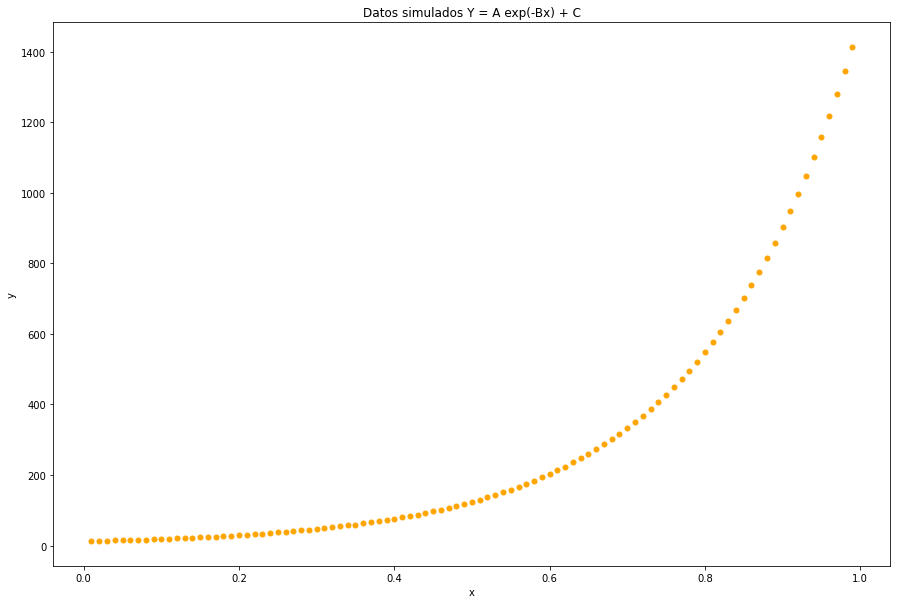

In [7]:
plt.figure(figsize = (15,10))
plt.title("Datos simulados Y = A exp(-Bx) + C")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df[:,0],df[:,1],c = "orange", s = 25);


### **Mean Square Root**

In [8]:
def mse (actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract (actual, pred)). mean() 

### **Simulacion Sugeno**

--- 0.03336954116821289 seconds ---
[ 17812.71576699 -17417.04042801   6882.56912995  -6955.53907093
  15756.99837948   3215.54503546]


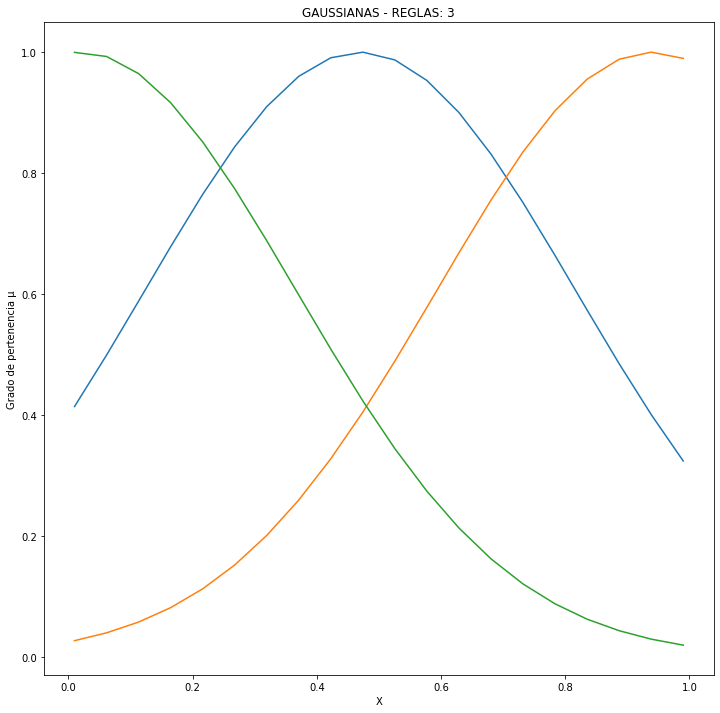

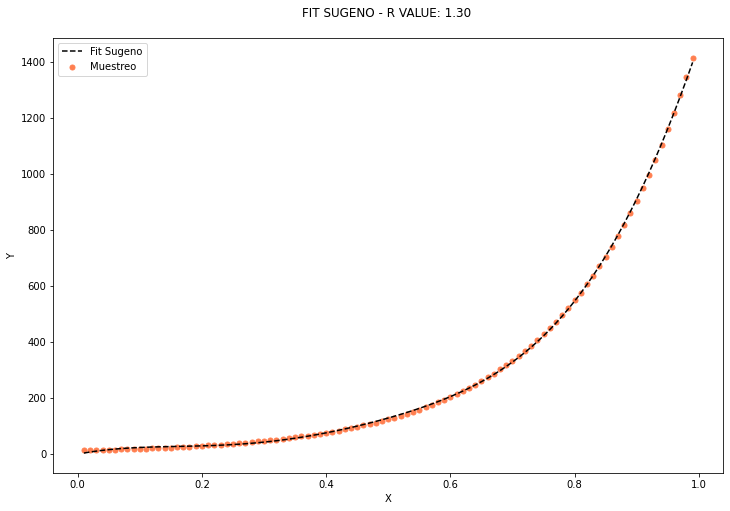

In [9]:
radii = 1.3

sim_fis = fis()
sim_fis.genfis(df,radii)
sim_fis.viewInputs()

r = sim_fis.evalfis(np.vstack(df[:,0]))

plt.figure(figsize=(12,8))
plt.title("FIT SUGENO - R VALUE: {:.2f} \n".format(radii))
plt.xlabel("X") # Agregamos labels a los ejes
plt.ylabel("Y")
plt.scatter(df[:,0],df[:,1],c="coral",s=25)
plt.plot(df[:,0],r,c="black",linestyle='--')
plt.legend(["Fit Sugeno","Muestreo" ]);

### **Calculo MSE**

In [10]:
print("Error cuadratico medio = {:.2f}".format(mse(r,df[:,1])))

Error cuadratico medio = 19.61


### **Agrego ruido Gaussiano**

In [115]:
from random import seed
from random import gauss

seed(1)
gauss(0,1)

1.2881847531554629

In [116]:
for i in range(df.shape[0]):
  df_ruido[i,0] = df[i,0]
  df_ruido[i,1] = df[i,1] + gauss(0,1)

df_ruido

array([[1.00000000e-02, 1.28486814e+01],
       [2.00000000e-02, 7.86830493e+00],
       [3.00000000e-02, 2.14255644e+01],
       [4.00000000e-02, 1.77828120e+01],
       [5.00000000e-02, 9.67888562e+00],
       [6.00000000e-02, 1.23813130e+01],
       [7.00000000e-02, 2.08204717e+01],
       [8.00000000e-02, 2.31857235e+01],
       [9.00000000e-02, 1.00844158e+01],
       [1.00000000e-01, 1.55421701e+01],
       [1.10000000e-01, 2.11608997e+01],
       [1.20000000e-01, 1.84692924e+01],
       [1.30000000e-01, 1.71855032e+01],
       [1.40000000e-01, 2.03597213e+01],
       [1.50000000e-01, 2.41079496e+01],
       [1.60000000e-01, 2.06274941e+01],
       [1.70000000e-01, 2.71442613e+01],
       [1.80000000e-01, 2.80318620e+01],
       [1.90000000e-01, 3.62064578e+01],
       [2.00000000e-01, 3.19407960e+01],
       [2.10000000e-01, 4.07998484e+01],
       [2.20000000e-01, 2.72459082e+01],
       [2.30000000e-01, 2.97574581e+01],
       [2.40000000e-01, 3.31885541e+01],
       [2.500000

### **Ploteo de modelo con ruido Gaussiano**

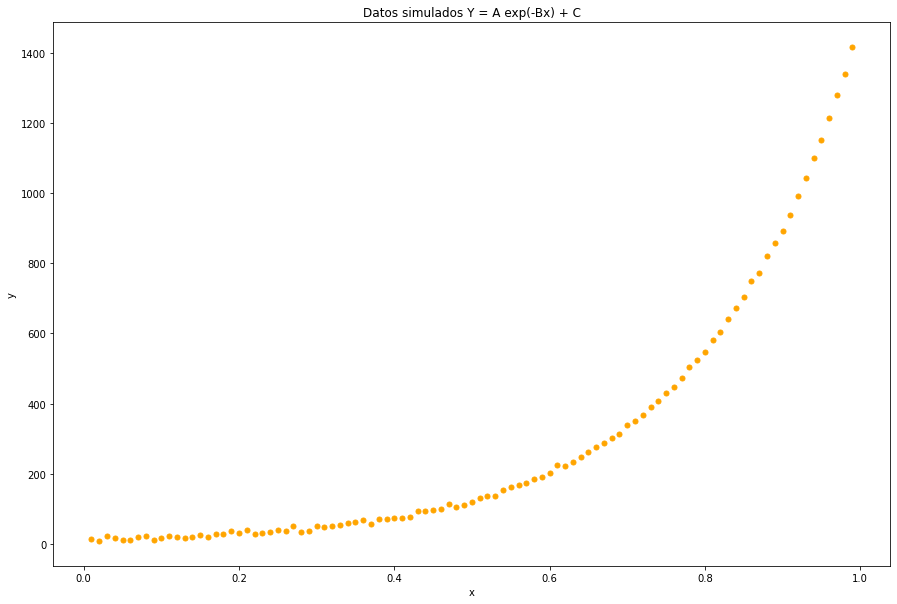

In [117]:
plt.figure(figsize = (15,10))
plt.title("Datos simulados Y = A exp(-Bx) + C")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df_ruido[:,0],df_ruido[:,1],c = "orange", s = 25);

### **Simulacion de Sugeno con modelo de Ruido Gaussiano**

--- 0.012434005737304688 seconds ---
[ 17880.59162643 -17316.73445826   7017.69924599  -7052.37212293
  15656.51678329   3250.18651583]


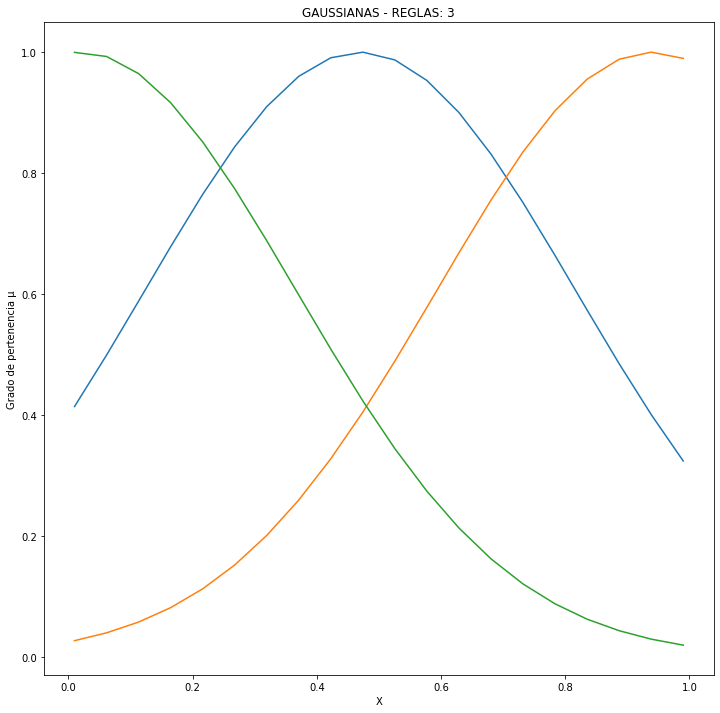

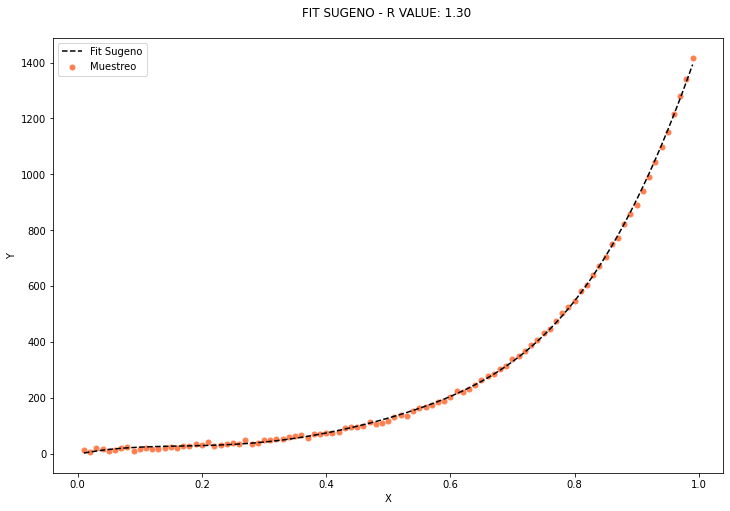

In [118]:
radii = 1.3

sim_fis = fis()
sim_fis.genfis(df,radii)
sim_fis.viewInputs()

r = sim_fis.evalfis(np.vstack(df_ruido[:,0]))

plt.figure(figsize=(12,8))
plt.title("FIT SUGENO - R VALUE: {:.2f} \n".format(radii))
plt.xlabel("X") # Agregamos labels a los ejes
plt.ylabel("Y")
plt.scatter(df_ruido[:,0],df_ruido[:,1],c="coral",s=25)
plt.plot(df[:,0],r,c="black",linestyle='--')
plt.legend(["Fit Sugeno","Muestreo" ]);

### **Calculo MSE modelo de ruido Gaussiano**

In [119]:
print("Error cuadratico medio = {:.2f}".format(mse(r,df_ruido[:,1])))

Error cuadratico medio = 48.99
